In [31]:
import warnings
warnings.filterwarnings("ignore")

from prop_comparison_methods import *

## Specify stages to analyze

In [32]:
#first we select the genotype 
genotype = 'ecadGFPnbG4'
#genotype = 'ecadGFPnbG4myoVI'

#some lists and dicts that we refer to later

#update names of devstages
devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }

#declare colors for each devstage and crosssection and region
color_dict = {
              '96hAEL':'#f1ef81',
              '120hAEL':'#efa636',
              'wL3':'#414243',
              '0hAPF':'#7d99cd', 
              '2hAPF':'#64a9dd', 
              '4hAPF':'#78cfdb',
              '6hAPF':'#71c382',
              'DV' : 'purple',
              'outDV' : 'green',
             }

columns = ['devstage', 'discName', 'region', 'k_dist', 'roi',
           'area','neighbour_number','elongation_tensor_norm_max', 
           'Qrr_geom_inPlane', 'Qphiphi', 'Qnn', 'Qrphi', 'Qrn', 'Qphin',
           'countInBin', 'cumcount',
           'k_dist_pathlength', #'k_dist_pathlength_poly' 
          ]

rois = ['outDV', 'DV']
devstages = [#"96hAEL",
             "wL3","0hAPF","2hAPF","4hAPF", "6hAPF",
]

############################################
# Dictionary of pairs of stages to compare #
############################################

#for the simulations, we use the cumulative version
devstage_combinations = pd.DataFrame({'devstage_init':[
                                                       'wL3','0hAPF','2hAPF','4hAPF' #diff between consecutive stages
                                                       #'wL3','wL3','wL3', #'wL3' #cumulative
    
                                                      ],
                                     'devstage_final':[
                                                       #'4hAPF',
                                                       '0hAPF','2hAPF','4hAPF','6hAPF' 
                                                      ],}
                                    )

## Plotting specifications

In [33]:
Large_font_size = 12
Medium_font_size = 7
Small_font_size = 5
lw = 1
text_kwargs = dict(ha='center', va='center', color='C1')

#setting figuresize - by default matplotlib uses inches
#size of A4 sheet - 
cm_ = 1/2.54  # centimeters in inches 
#set figsize like this - figsize=(3*cm_, 2*cm_)

#settings for quivers
quiver_scale=3
quiver_width=0.01
DV_width = np.sin(0.1931/2)/np.sin(0.8662) #around 0.1
#circ_plot_xlim = (-1.25,1.25)
#circ_plot_ylim = (-1.1, 1.4)

## Import data

In [34]:
#upload data
#df = pd.read_pickle('../data/DFallDiscsIncreaselimitcounts.pkl')
df = pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
#df = df[df['genotype'] == 'ecadGFPnbG4']
df = df[df['genotype'] == genotype]
df["devstage"] = [devstage_map[x] for x in df["devstage"].values]
df = df[columns]

In [35]:
df.head(3)

,devstage,discName,region,k_dist,roi,area,neighbour_number,elongation_tensor_norm_max,Qrr_geom_inPlane,Qphiphi,Qnn,Qrphi,Qrn,Qphin,countInBin,cumcount,k_dist_pathlength
0,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8_outDV,outDV,13,dorsal,1.646873,4,0.079496,-0.065859,0.056459,0.009400,0.031090,0.003897,0.033033,42.0,288.0,28.560460
1,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8_outDV,outDV,13,dorsal,6.991516,7,0.297667,-0.280260,0.288938,-0.008678,-0.057726,-0.009983,0.029122,42.0,288.0,31.961953
2,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8_outDV,outDV,13,dorsal,9.529885,6,0.178425,-0.039228,0.051418,-0.012190,-0.165394,-0.004449,0.012512,42.0,288.0,32.296625


In [36]:
#Here we get a dictionary for the maximum N for each disc
#df_limit = pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
#df_limit = df_limit[df_limit['genotype'] == genotype]
#df_limit["devstage"] = [devstage_map[x] for x in df_limit["devstage"].values]
#df_limit = df_limit[columns]
#
#df_Nmax_for_each_disc = df_limit[["discName","cumcount","k_dist_pathlength"]].groupby("discName").agg("max")
#df_Nmax_for_each_disc.columns = ["discName", "Nmax"]

In [37]:
devstages

['wL3', '0hAPF', '2hAPF', '4hAPF', '6hAPF']

In [38]:
# maximum N
temp = df.query("devstage in @devstages")[["region", "discName", "cumcount"]].groupby(["region", "discName"]).agg(["max",]).reset_index()
temp.groupby("region").agg(["mean", "std"])

cumcount           
               max           
              mean        std
region                       
DV      164.366667  13.963582
outDV   848.833333  54.405935

### For each disc, compute average quantities within each ring

In [39]:
#discName contains the name of the disc as well as region
groupby_cols = ['devstage', 'region', 'discName', 'k_dist']
#here we pool cells within a ring and calculate the mean
df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index() 
#we offset k_dist values if the rings do not start with k_dits = 0
k_dist_offset = df.groupby(['discName']).k_dist.agg('min')#.reset_index().set_index('discName') #some discs can have k starting from non-zero value, so we offset them by the starting k
df_pool_k['k_dist'] = df_pool_k['k_dist'] - k_dist_offset[df_pool_k['discName'].values].values #offsetting k values


#scale pathlength
#df_pool_k['pathlength_scaled'] = df_pool_k['k_dist_pathlength']/pathlength_max[df_pool_k['discName'].values].values
#df_Nmax_for_each_disc.loc[df_pool_k['discName'].values,"k_dist_pathlength"].values #pathlength_max[df_pool_k['discName'].values].values
#scale pathlength
pathlength_max = df_pool_k.groupby(['discName']).k_dist_pathlength.agg('max')
df_pool_k['pathlength_scaled'] = df_pool_k['k_dist_pathlength']/pathlength_max[df_pool_k['discName'].values].values
#df_pool_k['pathlength_scaled'] = df_pool_k['k_dist_pathlength']/df_Nmax_for_each_disc.loc[df_pool_k['discName'].values,"k_dist_pathlength"].values


In [40]:
#compute Qnorm and exponential of Qnorm - to be used later

#function to compute area weighted average
wm = lambda x: np.average(x, weights=df.loc[x.index, "area"])

df_pool_areaWeighted_k = df.groupby(groupby_cols).agg(Qrr_geom_inPlane = pd.NamedAgg(column = 'Qrr_geom_inPlane', aggfunc = wm),
                                                      Qrphi = pd.NamedAgg(column = 'Qrphi', aggfunc = wm),
                                                      Qphiphi = pd.NamedAgg(column = 'Qphiphi', aggfunc = wm),
                                                     ).reset_index() 
df_pool_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]] = df_pool_areaWeighted_k[["Qrr_geom_inPlane", "Qrphi", "Qphiphi"]]

df_pool_k['Qnorm'] = np.sqrt(df_pool_k['Qrr_geom_inPlane']**2 + df_pool_k['Qrphi']**2)
df_pool_k['exp_signed_Qnorm'] = np.exp(np.sign(df_pool_k['Qrr_geom_inPlane'])*df_pool_k['Qnorm'])

In [41]:
df_pool_k.columns

Index(['devstage', 'region', 'discName', 'k_dist', 'area', 'neighbour_number',
       'elongation_tensor_norm_max', 'Qrr_geom_inPlane', 'Qphiphi', 'Qnn',
       'Qrphi', 'Qrn', 'Qphin', 'countInBin', 'cumcount', 'k_dist_pathlength',
       'pathlength_scaled', 'Qnorm', 'exp_signed_Qnorm'],
      dtype='object')

### For each developmental stage, average over discs

In [42]:
groupby_cols = ['devstage', 'region', 'k_dist']
#here we pool discs within a devstage and calculate the mean and std
df_pool_devstage = df_pool_k.groupby(groupby_cols).agg(['mean', 'std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_pool_devstage.columns]
df_pool_devstage.columns = colnames #removing multi-indexing

df_pool_devstage.head()

,devstage,region,k_dist,area_mean,area_std,neighbour_number_mean,neighbour_number_std,elongation_tensor_norm_max_mean,elongation_tensor_norm_max_std,Qrr_geom_inPlane_mean,...,cumcount_mean,cumcount_std,k_dist_pathlength_mean,k_dist_pathlength_std,pathlength_scaled_mean,pathlength_scaled_std,Qnorm_mean,Qnorm_std,exp_signed_Qnorm_mean,exp_signed_Qnorm_std
0,0hAPF,DV,0,6.138776,1.899830,5.600000,0.565685,0.236052,0.074967,-0.057797,...,2.419048,0.626234,0.000000,0.000000,0.000000,0.000000,0.149957,0.095187,0.886789,0.113648
1,0hAPF,DV,1,7.049269,0.976519,5.859694,0.240154,0.214965,0.057095,-0.044956,...,7.296806,1.024164,2.740585,0.197002,0.033959,0.001244,0.077995,0.032937,0.936688,0.052501
2,0hAPF,DV,2,6.803410,0.972501,5.862647,0.250389,0.249500,0.057656,0.014085,...,13.939177,1.583098,5.952463,0.394122,0.073854,0.004414,0.065115,0.034069,1.028614,0.074245
3,0hAPF,DV,3,6.795584,1.264079,5.936568,0.161895,0.220404,0.025238,0.047206,...,20.804262,2.786416,9.463610,0.746017,0.117493,0.009867,0.071269,0.024236,1.057808,0.055874
4,0hAPF,DV,4,6.757545,1.057610,6.004347,0.113781,0.224231,0.026976,0.070369,...,27.901782,3.594859,12.758039,1.085376,0.158335,0.013435,0.087803,0.050519,1.088082,0.063606


In [43]:
#compute Qnorm
df_pool_devstage['Qnorm_mean'] =  np.sqrt( df_pool_devstage['Qrr_geom_inPlane_mean']**2 + df_pool_devstage['Qrphi_mean']**2)#Norm of mean
df_pool_devstage['Qnorm_std'] = (df_pool_devstage['Qrr_geom_inPlane_mean']*df_pool_devstage['Qrr_geom_inPlane_std'] + df_pool_devstage['Qrphi_mean']*df_pool_devstage['Qrphi_std'])/df_pool_devstage['Qnorm_mean']

df_pool_devstage['exp_signed_Qnorm_mean'] = np.exp(np.sign(df_pool_devstage['Qrr_geom_inPlane_mean'])*df_pool_devstage['Qnorm_mean'])
df_pool_devstage['exp_signed_Qnorm_std'] = df_pool_devstage['exp_signed_Qnorm_mean']*df_pool_devstage['Qnorm_std']


## Pathlength analysis

As we will use $N$(cumcount) to track regions between discs, we want to fit a polynomial to get the mapping between N and the reference scaled pathlength($p$).
The scaled pathlength $p$ is a dimensionless coordinate for the distance from the $k = 0$ location.
In the previous cells we already computed $p$ as $\text{k_dist_pathlength}/\max(\text{k_dist_pathlength})$ for each discName.

In [44]:
k_scaled_dist_dict = dict() #a dictionary for storing the polynomial object for fitting between fractional pathlength and N
devstage = "wL3"

from scipy.optimize import curve_fit
#for DV
roi = "DV"
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
#doing a linear fit going through 0,0
def func(x, a):
    return a*x
popt, pcov = curve_fit(func, df_roi_stage['cumcount_mean'], df_roi_stage['pathlength_scaled_mean'])
p_DV_coeff = popt[0]
def p_DV(x):
    return(p_DV_coeff*x)
k_scaled_dist_dict[roi] = p_DV #coeffs[1] is supposed to be zero (very small value compared to 1 which is the max value of scaled dist)

#for outDV
roi = "outDV"
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
#doing a linear fit going through 0,0
def func(x, a, b, c, d, e):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x
popt, pcov = curve_fit(func, df_roi_stage['cumcount_mean'], df_roi_stage['pathlength_scaled_mean'])
p_outDV_coeff = popt
def p_outDV(x):
    return p_outDV_coeff[0]*x**5 + p_outDV_coeff[1]*x**4 + p_outDV_coeff[2]*x**3 + p_outDV_coeff[3]*x**2 + p_outDV_coeff[4]*x
k_scaled_dist_dict[roi] = p_outDV #coeffs[1] is supposed to be zero (very small value compared to 1 which is the max value of scaled dist)

df_pool_k["ref_pathlength_scaled"] = df_pool_k.apply(lambda row: k_scaled_dist_dict[row['region']](row["cumcount"]),axis = 1)
df_pool_devstage["ref_pathlength_scaled"] = df_pool_devstage.apply(lambda row: k_scaled_dist_dict[row['region']](row['cumcount_mean']),axis = 1)

In [45]:
#save a csv file to get the max pathlength for each region and devstage
groupby_cols = ["devstage", "region"]
max_pathlength_df = df_pool_devstage[groupby_cols+["k_dist_pathlength_mean"]].groupby(groupby_cols).agg(max).reset_index()
region_to_crosssection_map = {"DV":"Along_DV", "outDV":"Across_DV"}
max_pathlength_df["crosssection"] = [region_to_crosssection_map[x] for x in max_pathlength_df["region"].values]
#here we should also include width_DV/2 - get the width_DV for each stage from Jana
max_pathlength_df.columns = ["devstage", "region", "max_pathlength", "crosssection"]
#save
max_pathlength_df.to_csv("../data/max_pathlength_df_" + genotype + ".csv",index=False)
max_pathlength_df

,devstage,region,max_pathlength,crosssection
0,0hAPF,DV,80.798705,Along_DV
1,0hAPF,outDV,64.811345,Across_DV
2,120hAEL,DV,44.245798,Along_DV
3,120hAEL,outDV,41.386468,Across_DV
4,2hAPF,DV,91.275397,Along_DV
5,2hAPF,outDV,72.643506,Across_DV
6,4hAPF,DV,100.036092,Along_DV
7,4hAPF,outDV,78.372722,Across_DV
8,6hAPF,DV,199.048206,Along_DV
9,6hAPF,outDV,105.398175,Across_DV


at stage wL3, roi outDV max P (um) : 58.66
at stage 0hAPF, roi outDV max P (um) : 64.81
at stage 2hAPF, roi outDV max P (um) : 72.64
at stage 4hAPF, roi outDV max P (um) : 78.37
at stage 6hAPF, roi outDV max P (um) : 105.4
at stage wL3, roi DV max P (um) : 60.88
at stage 0hAPF, roi DV max P (um) : 80.8
at stage 2hAPF, roi DV max P (um) : 91.28
at stage 4hAPF, roi DV max P (um) : 100.04
at stage 6hAPF, roi DV max P (um) : 199.05


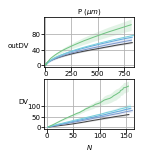

In [46]:
figsize = (5*cm_, 6*cm_)

nbcols = 1#len(devstages)
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)

for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = ''
        if (j == 0) or (nbcols == 1):
            ylabel = ''#'P ' + r'$(\mu m)$'
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$N$'
        if roi == 'DV':
            xticks = [0, 50, 100, 150]
            yticks = [0, 50, 100]
            #xlim = (-1, 25)
            xlim = (-5,165)
            #ylim = (-2, 27)
            title = ''
        else:
            xticks = [0, 250, 500, 750]
            yticks = [0, 40, 80]
            xlim = (-10,850)
            #xlim = (-1, 25)
            #ylim = (-2, 27)
            title = 'P ' + r'$(\mu m)$'#devstage
        
        ax = get_subplot(ax, df = None, #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'cumcount', y_col = 'k_dist_pathlength', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =lw, 
                         mean_color=color_dict[devstage],mean_linewidth =lw,
                         mean_label=devstage, ylabelpad = 0,
                        )
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = 0)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = 0)
        #ax.legend(fontsize = Small_font_size)
        ax.grid(True)
        #ax.text(x = 100, y = 10,
        #    s = "max P " + r"$(\mu m) : $" + str(max(np.round(df_pool_devstage.query(query_str)["k_dist_pathlength_mean"],2))))
        print("at stage "+ devstage + ", roi "+ roi + " max P (um) : " + str(max(np.round(df_pool_devstage.query(query_str)["k_dist_pathlength_mean"],2))))
    
    
    
fig.tight_layout(pad = 0.2)

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, pad = 2*Medium_font_size, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = -0.02,)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)

os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/P_vs_N_' + genotype + '.pdf', bbox_inches = 'tight')


In [47]:
df_pool_devstage[["devstage", "roi","cumcount"]].groupby(["devstage", "roi"]).agg("max")

KeyError: "['roi', 'cumcount'] not in index"

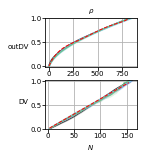

In [49]:
#devstage = "wL3"
figsize = (5*cm_, 6*cm_)

nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = r'$\rho$'
        if (j == 0) or (nbcols == 1):
            ylabel =''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$N$'
        if roi == 'DV':
            #xticks = [0, 50, 100, 150]
            yticks = [0, 0.5, 1]
            #xlim = (-1, 22)
            #xlim = (-5,155)
            #ylim = (-2, 27)
        else:
            #xticks = [0, 250, 500, 750]
            yticks = [0, 0.5, 1]
            #xlim = (-10,780)
            #xlim = (-1, 22)
            #ylim = (-2, 27)
        
        ax = get_subplot(ax, df = None, #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'cumcount', y_col = 'pathlength_scaled', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =lw, 
                         mean_color=color_dict[devstage],mean_linewidth =lw,
                         mean_label=devstage, ylabelpad = 0,
                        )
        
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = 0)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        ax.set_yticks(yticks)
        ax.set_ylim(-0.01,1.01)
        
    #fit line for the last stage
    df_roi_stage = df_pool_devstage.query(query_str)
    ax.plot(df_roi_stage['cumcount_mean'], df_roi_stage['ref_pathlength_scaled'], linestyle = '--', color = "red", linewidth = lw, label = 'fit')

    ax.grid(visible=True)
    #ax.legend(fontsize = 20)


fig.tight_layout(pad = 0.2)


plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, pad = Medium_font_size, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)

os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/rho_vs_N_Ref_' + genotype + '.pdf', bbox_inches = 'tight')



In [50]:
df_pool_devstage

,devstage,region,k_dist,area_mean,area_std,neighbour_number_mean,neighbour_number_std,elongation_tensor_norm_max_mean,elongation_tensor_norm_max_std,Qrr_geom_inPlane_mean,...,cumcount_std,k_dist_pathlength_mean,k_dist_pathlength_std,pathlength_scaled_mean,pathlength_scaled_std,Qnorm_mean,Qnorm_std,exp_signed_Qnorm_mean,exp_signed_Qnorm_std,ref_pathlength_scaled
0,0hAPF,DV,0,6.138776,1.899830,5.600000,0.565685,0.236052,0.074967,-0.057797,...,0.626234,0.000000,0.000000,0.000000,0.000000,0.070636,-0.138054,0.931801,-0.128639,0.015063
1,0hAPF,DV,1,7.049269,0.976519,5.859694,0.240154,0.214965,0.057095,-0.044956,...,1.024164,2.740585,0.197002,0.033959,0.001244,0.049672,-0.009776,0.951542,-0.009302,0.045437
2,0hAPF,DV,2,6.803410,0.972501,5.862647,0.250389,0.249500,0.057656,0.014085,...,1.583098,5.952463,0.394122,0.073854,0.004414,0.017667,0.070687,1.017824,0.071946,0.086798
3,0hAPF,DV,3,6.795584,1.264079,5.936568,0.161895,0.220404,0.025238,0.047206,...,2.786416,9.463610,0.746017,0.117493,0.009867,0.047550,0.049418,1.048699,0.051824,0.129546
4,0hAPF,DV,4,6.757545,1.057610,6.004347,0.113781,0.224231,0.026976,0.070369,...,3.594859,12.758039,1.085376,0.158335,0.013435,0.070963,0.050287,1.073541,0.053985,0.173742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,wL3,outDV,17,5.568337,0.221739,5.912417,0.101100,0.174941,0.026667,0.004443,...,11.499940,45.840916,1.638181,0.781528,0.010548,0.006548,0.023005,1.006569,0.023156,0.791387
323,wL3,outDV,18,5.805343,0.284228,5.854712,0.106207,0.173301,0.017757,0.018589,...,12.865087,48.966382,1.653362,0.834848,0.010211,0.019185,0.032226,1.019370,0.032851,0.842047
324,wL3,outDV,19,5.856530,0.586428,5.945530,0.187731,0.178540,0.012641,-0.014783,...,18.873262,52.380939,1.880790,0.892956,0.002116,0.018209,-0.007273,0.981956,-0.007142,0.887005
325,wL3,outDV,20,5.945019,0.473903,5.861282,0.151125,0.186270,0.012375,-0.013621,...,24.089417,55.356928,1.970896,0.943704,0.005109,0.013713,-0.016921,0.986380,-0.016691,0.933849


In [51]:

devstage = 'wL3'
roi = 'outDV'
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
max_pathlength_outDV = max(df_roi_stage['k_dist_pathlength_mean'])

roi = 'DV'
query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
df_roi_stage = df_pool_devstage.query(query_str)
max_pathlength_DV = max(df_roi_stage['k_dist_pathlength_mean'])

max_pathlength = (max_pathlength_outDV + max_pathlength_DV)/2


print('Max pathlength at upcrawling stage')
print(max_pathlength)

Max pathlength at upcrawling stage
59.767084126366555


In [52]:
max(df_pool_devstage.query("devstage == 'wL3' and region == 'DV'")["ref_pathlength_scaled"])

0.965172284641338

## Area analysis

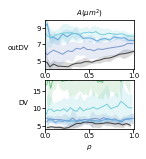

In [53]:

figsize = (5*cm_, 6*cm_)

nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)



for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = r'$A(\mu m^2)$' 
        if (j == 0) or (nbcols == 1):
            ylabel =''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            yticks = [5, 10, 15]
            xlim = (-0.01,1.01)
            ylim = (4, 18)
        else:
            xticks = [0, 0.5, 1,]
            yticks = [5, 7, 9 ]
            xlim = (-0.01,1.01)
            ylim = (4, 10)
        
        ax = get_subplot(ax, df = None,  #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'ref_pathlength_scaled', y_col = 'area', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =lw, 
                         mean_color=color_dict[devstage],mean_linewidth =lw,
                         mean_label=devstage, ylabelpad = 0,
                        )
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = 0)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        
    ax.grid(visible=False)
    #ax.legend(fontsize = 12)
    
fig.tight_layout(pad = 0.2)

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, pad = Medium_font_size, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/area_vs_rho_' + genotype + '.pdf', bbox_inches = 'tight')


In [54]:
#function to compare between pairs of stages
prop = 'area'

[area_diff, area_diff_stat] = get_prop_differences(df_pool_k, prop = prop,operation = 'divide-sqrt',
                                                   devstage_combinations=devstage_combinations, 
                                                   fit_param = 'ref_pathlength_scaled_beta_mean'
                                                  )

fit_lambdas_df = compile_fit_lambdas_for_sim(area_diff_stat, fit_lambdas_df = None, prop = "area", lambda_name = "lambda_isotropic_coeffs")

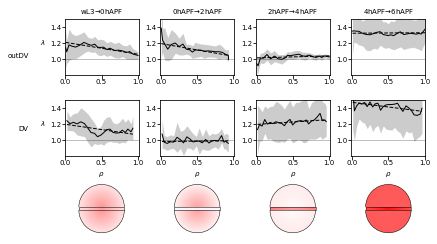

In [55]:
#plotting


figsize = (15*cm_, 9*cm_)

nbcols = len(devstage_combinations)
nbrows = 3

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)

for j in range(nbcols):
    #range(nbrows)
    devstage_init = devstage_combinations.loc[j,'devstage_init']
    devstage_final = devstage_combinations.loc[j,'devstage_final']

    for i in range(2):
        roi = rois[i]
        
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = devstage_init + r'$ \to $' + devstage_final
        if j == 0:
            ylabel = r'$\lambda$'
            #ylabel = ''
        if i == 1:#nbrows-1:
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            yticks = [1, 1.2, 1.4] 
            xlim = (-0.01, 1.01)
            ylim = (0.8, 1.5) 
        else:
            xticks = [0, 0.5, 1]
            yticks = [1,1.2, 1.4]
            xlim = (-0.01, 1.01)
            ylim = (0.8, 1.5)
        
        ax = get_subplot(ax, df = None, #area_diff, 
                         stat_df = area_diff_stat, query_str = query_str, x_col = 'ref_pathlength_scaled_beta', y_col = prop+'_diff', 
                         mean_linewidth= lw, mean_alpha = 0.2, #properties of the mean line
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         error_style='fill_between',
                         mean_color = "black",
                        )

        ax = get_subplot(ax, df = None, stat_df = area_diff_stat, query_str = query_str, 
                         x_col_mean='ref_pathlength_scaled_beta_mean', y_col_mean ='fit_'+prop+'_diff',
                         xlabel = xlabel, ylabel = ylabel, title = title, ylabelpad=20,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         mean_linewidth=lw, mean_linestyle='--',
                         error_style = None, mean_label = 'fit',
                         mean_color = "black", #color_dict[devstage_init]
                        )
        
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = Medium_font_size)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        ax.axhline(y = 1.0, linewidth = lw/2, color = "gray", zorder = 0)
        
        #ax.legend()
        ax.grid(visible=False)
        
    ax = axs[2,j]
    ax = get_isotropic_subplot(ax, stage_init=devstage_init, stage_final=devstage_final,fit_lambdas_df = fit_lambdas_df,
                               boundary_lw = lw/2,DV_width = DV_width,
                              )
        
    
        
        
fig.tight_layout(pad = 0.2)

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1, 2]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['', 'DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, 
                    pad = 0, # if two columns
                    #pad = 30, #if four columns
                    rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)

os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/lambda_isotropic_' + genotype + '.pdf', bbox_inches = 'tight')


In [56]:
fit_lambdas_df.head()

,stage,stage_name,prop,value,stage_init,stage_final,roi
0,0,wL3 to 0hAPF,lambda_isotropic_coeffs,"[-0.1466314118835658, 1.2061157068172164]",wL3,0hAPF,outDV
1,1,0hAPF to 2hAPF,lambda_isotropic_coeffs,"[-0.15787417016378213, 1.1911198379881764]",0hAPF,2hAPF,outDV
2,2,2hAPF to 4hAPF,lambda_isotropic_coeffs,"[0.024352640924532057, 1.013409740373247]",2hAPF,4hAPF,outDV
3,3,4hAPF to 6hAPF,lambda_isotropic_coeffs,"[0.0062259322605448825, 1.319361586379148]",4hAPF,6hAPF,outDV
4,0,wL3 to 0hAPF,inDV_lambda_isotropic_coeffs,"[-0.13199526622899696, 1.1932208575078265]",wL3,0hAPF,DV


## Elongation analysis

[]

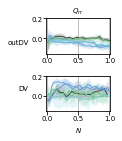

In [57]:
#rois = ['outDV', 'DV']
#devstages = ['upcrawling','whitePupa','2hAPF','4hAPF']



figsize = (5*cm_, 6*cm_)

nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = r'$Q_{rr}$'
        if (j == 0) or (nbcols == 1):
            ylabel = ''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$N$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            #yticks = [0, 10, 20]
            xlim = (-0.01, 1.01)
            #ylim = (-2, 27)
        else:
            xticks = [0, 0.5, 1]
            #yticks = [0, 10, 20]
            xlim = (-0.01, 1.01)
            #ylim = (-2, 27)
        
        ax = get_subplot(ax, df = None, #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'ref_pathlength_scaled', y_col = 'Qrr_geom_inPlane', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =lw, 
                         mean_color=color_dict[devstage],mean_linewidth =lw,
                         mean_label=devstage, ylabelpad = 0,
                        )
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = 0)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        
    ax.grid(visible = True)
    #ax.legend(fontsize = 12)
    
fig.tight_layout()

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, pad = 2.5*Medium_font_size, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, )

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



#os.makedirs('plots/',exist_ok=True)
#plt.savefig('plots/k_vs_N_' + genotype + '.pdf', bbox_inches = 'tight')


[]

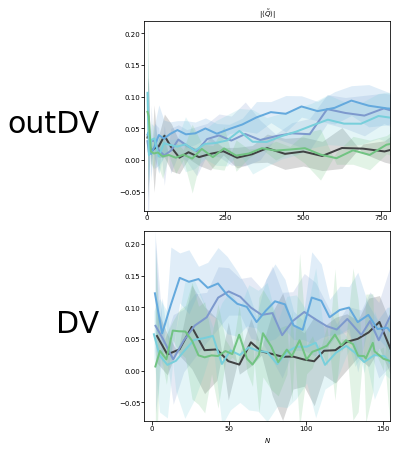

In [58]:
#rois = ['outDV', 'DV']
#devstages = ['upcrawling','whitePupa','2hAPF','4hAPF']


nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = (4.5*nbcols, (10/3)*nbrows)
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = r'$|\langle  \tilde{Q} \rangle |$'
        if (j == 0) or (nbcols == 1):
            ylabel =''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$N$'
        if roi == 'DV':
            xticks = [0, 50, 100, 150]
            #yticks = [0, 10, 20]
            xlim = (-5,155)
            ylim = (-0.08, 0.22)
        else:
            xticks = [0, 250, 500, 750]
            #yticks = [0, 10, 20]
            xlim = (-10,780)
            ylim = (-0.08, 0.22)
        
        ax = get_subplot(ax, df = None, #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'cumcount', y_col = 'Qnorm', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =1.2, 
                         mean_color=color_dict[devstage],mean_linewidth =2,
                         mean_label=devstage, ylabelpad = 0,
                        )
        
    ax.grid(visible = False)
    #ax.legend(fontsize = 12)
    ax.set_xlabel(xlabel, fontsize = Medium_font_size)
    ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = Medium_font_size)
    ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
    ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
    ax.axhline(y = 1.0, linewidth = lw/2, color = "gray", zorder = 0)
    
fig.tight_layout()

plt.xlabel('', fontsize = 40, labelpad = 30)
plt.ylabel('', fontsize = 40, labelpad = 70, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = 15, pad = 20, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = 30, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



#os.makedirs('plots/',exist_ok=True)
#plt.savefig('plots/k_vs_N_' + genotype + '.pdf', bbox_inches = 'tight')


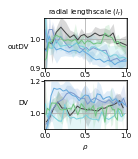

In [59]:

figsize = (5*cm_, 6*cm_)

nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = "radial lengthscale " + r'$(l_r)$'
        if (j == 0) or (nbcols == 1):
            ylabel = ''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            #yticks = [0, 10, 20]
            xlim = (-0.01,1.01)
            ylim = (0.9, 1.21)
        else:
            xticks = [0, 0.5, 1]
            #yticks = [0, 10, 20]
            xlim = (-0.01,1.01)
            ylim = (0.9, 1.07)
        
        ax = get_subplot(ax, df = None, #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'ref_pathlength_scaled', y_col = 'exp_signed_Qnorm', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =lw, 
                         mean_color=color_dict[devstage],mean_linewidth =lw,
                         mean_label=devstage, ylabelpad = 0,
                        )
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = 0)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        
    ax.grid(visible = True)
    #ax.legend(fontsize = 12)
    
fig.tight_layout(pad = 0.2)

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, pad = Medium_font_size, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/radial_lengthscale_vs_rho_' + genotype + '.pdf', bbox_inches = 'tight')


In [60]:

prop = 'exp_signed_Qnorm'

[el_diff, el_diff_stat] = get_prop_differences(df_pool_k, prop = prop,operation = 'divide',
                                                   devstage_combinations=devstage_combinations,
                                                   fit_param='ref_pathlength_scaled_beta_mean',
                                              )
fit_lambdas_df = compile_fit_lambdas_for_sim(el_diff_stat, fit_lambdas_df = fit_lambdas_df, prop = prop, lambda_name = "lambda_Q_coeffs")

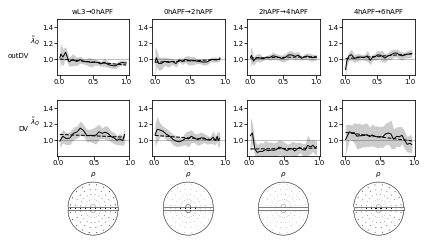

In [61]:
#plotting

figsize = (15*cm_, 9*cm_)

nbcols = len(devstage_combinations)
nbrows = 3

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)

for j in range(nbcols):

    devstage_init = devstage_combinations.loc[j,'devstage_init']
    devstage_final = devstage_combinations.loc[j,'devstage_final']    
    
    for i in range(2):
        roi = rois[i]

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = devstage_init + r'$ \to $' + devstage_final
        if j == 0:
            ylabel = r'$\tilde{\lambda}_{Q}$'
        if i == 1:#nbrows-1:
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            yticks = [1,1.2, 1.4 ] 
            #xlim = (0,155)
            ylim = (0.8, 1.5) 
        else:
            xticks = [0, 0.5, 1]
            yticks = [1, 1.2, 1.4]
            #xlim = (0,780)
            ylim = (0.8, 1.5)
        
        ax = get_subplot(ax, df = None, #el_diff, 
                         stat_df = el_diff_stat, query_str = query_str, x_col = 'ref_pathlength_scaled_beta', y_col = prop+'_diff', 
                         mean_linewidth= lw, mean_alpha = 0.2, #properties of the mean line
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         error_style='fill_between', mean_color = "black",#color_dict[devstage_init], 
                        )

        ax = get_subplot(ax, df = None, stat_df = el_diff_stat, query_str = query_str, 
                         x_col_mean='ref_pathlength_scaled_beta_mean', y_col_mean ='fit_'+prop+'_diff',
                         xlabel = xlabel, ylabel = ylabel, title = title, ylabelpad=30,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         mean_linewidth=lw, mean_linestyle='--',
                         error_style = None, mean_label = 'fit', mean_color = "black",#color_dict[devstage_init],
                        )
        
        #ax.legend()
        ax.grid(visible=False)
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = Medium_font_size)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        ax.axhline(y = 1.0, linewidth = lw/2, color = "gray", zorder = 0)
    
    ax = axs[2,j]
    ax = get_nematic_subplot(ax, stage_init=devstage_init, stage_final=devstage_final, lambda_name = "lambda_Q_coeffs", fit_lambdas_df=fit_lambdas_df,
                             quiver_scale=quiver_scale, quiver_width=quiver_width, boundary_lw=lw/2, DV_width = DV_width,
                            )
        
        
fig.tight_layout(pad = 0.2)

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1, 2]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['', 'DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, 
                    pad = 4*Medium_font_size, # if two columns
                    rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size,  x = 0)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/lambda_elongation_' + genotype + '.pdf', bbox_inches = 'tight')


## Rearrangement analysis

In [62]:
#df = pd.read_pickle('../data/DFallDiscsIncreaselimitcounts.pkl')
#df = pd.read_pickle('../data/DFallDiscslimitcounts.pkl')
#df = df[df['genotype'] == 'ecadGFPnbG4']
#df = df[df['genotype'] == 'ecadGFPnbG4myoVI']
#genotype = 'ecadGFPnbG4myoVI'


#df = df[df['genotype'] == genotype]

#devstages = ["96hAEL","wL3","0hAPF","2hAPF","4hAPF","6hAPF",]
#rois = ['outDV', 'DV']
#df["devstage"] = [devstage_map[x] for x in df["devstage"].values]

#ref_pathlength_scaled_beta
#devstages = ['96hAEL', 'upcrawling','whitePupa','2hAPF','4hAPF','6hAPF']

[k_N_alldiscs, k_N_mean] = analyze_ring_cell_numbers(df, devstages = devstages)


[k_diff, k_diff_stat] = get_k_differences(k_N_alldiscs, devstage_combinations = devstage_combinations, rois = rois, fit_param = 'ref_pathlength_scaled_beta_mean', N_ref_pathlength_dict = k_scaled_dist_dict)

#k_diff["ref_pathlength_scaled_beta"] = k_diff.apply(lambda row: k_scaled_dist_dict[row['roi']](row["N_beta"]),axis = 1)
#k_diff_stat["ref_pathlength_scaled_beta"] = k_diff_stat.apply(lambda row: k_scaled_dist_dict[row['roi']](row['N_beta_mean']),axis = 1)

prop = "lambda_rearrangement"
fit_lambdas_df = compile_fit_lambdas_for_sim(k_diff_stat, fit_lambdas_df = fit_lambdas_df, prop = prop, lambda_name = "lambda_rearrangement_coeffs")

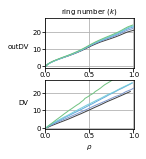

In [63]:

figsize = (5*cm_, 6*cm_)

nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = "ring number " + r'$(k)$'
        if (j == 0) or (nbcols == 1):
            ylabel = ''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            yticks = [0, 10, 20]
            xlim = (-0.01,1.01)
            ylim = (-1, 28)
        else:
            xticks = [0, 0.5, 1]
            yticks = [0, 10, 20]
            xlim = (-0.01,1.01)
            ylim = (-1, 28)
        
        ax = get_subplot(ax, df = None, #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'ref_pathlength_scaled', y_col = 'k_dist', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =lw, 
                         mean_color=color_dict[devstage],mean_linewidth =lw,
                         mean_label=devstage, ylabelpad = 0,
                        )
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = 0)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        
    ax.grid(visible = True)
    #ax.legend(fontsize = 12)
    
fig.tight_layout(pad = 0.2)

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, pad = Medium_font_size, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/k_vs_rho_' + genotype + '.pdf', bbox_inches = 'tight')


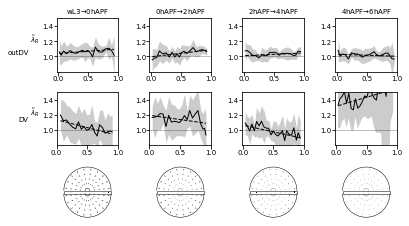

In [64]:
figsize = (15*cm_, 9*cm_)

nbcols = len(devstage_combinations)
nbrows = 3

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)


for j in range(nbcols):
    
    devstage_init = devstage_combinations.loc[j,'devstage_init']
    devstage_final = devstage_combinations.loc[j,'devstage_final']
    
    for i in range(2):

        roi = rois[i]
        
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = devstage_init + r'$ \to $' + devstage_final
        if j == 0:
            ylabel = r'$\tilde{\lambda}_{R}$'
        if i == nbrows-1:
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            yticks = [1, 1.2, 1.4,] 
            #xlim = (0,155)
            ylim = (0.8, 1.5) 
        else:
            xticks = [0, 0.5, 1]
            yticks = [1, 1.2, 1.4,]
            #xlim = (0,780)
            ylim = (0.8, 1.5)
        
        ax = get_subplot(ax, df = None,#k_diff, 
                         stat_df=k_diff_stat, query_str = query_str, x_col = 'ref_pathlength_scaled_beta_mean', y_col = 'lambda_rearrangement', 
                         mean_linewidth=lw,
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         mean_color="black", #color_dict[devstage_init], 
                        )
        ax = get_subplot(ax, df = None, 
                         stat_df = k_diff_stat, query_str = query_str, 
                         x_col_mean='ref_pathlength_scaled_beta_mean', y_col_mean ='fit_lambda_rearrangement',
                         mean_linewidth=lw,
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         mean_linestyle='--',error_style = None, mean_label = 'fit',
                         mean_color="black"#color_dict[devstage_init], 
                        )
        #ax.legend()
        ax.grid(visible=False)
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = Medium_font_size)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        ax.axhline(y = 1.0, linewidth = lw/2, color = "gray", zorder = 0)
        
    ax = axs[2,j]
    ax = get_nematic_subplot(ax, stage_init=devstage_init, stage_final=devstage_final, lambda_name = "lambda_rearrangement_coeffs", fit_lambdas_df=fit_lambdas_df,
                             quiver_scale=quiver_scale, quiver_width=quiver_width, boundary_lw=lw/2, DV_width = DV_width,
                            )
        
fig.tight_layout()

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1, 2]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['', 'DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, 
                    pad = 4*Medium_font_size, # if two columns
                    #pad = 30, #if four columns
                    rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = 0)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)

os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/lambda_rearrangement_' + genotype + '.pdf', bbox_inches = 'tight')

## Getting anisotropic lambda as product of elongation and rearrangement

In [65]:
#merge k_diff and el_diff
k_diff_w_aniso = pd.merge(k_diff, el_diff[["disc_combination", "k_beta", "exp_signed_Qnorm_diff"]], on = ["disc_combination", "k_beta"])
#multiply the two lambdas
k_diff_w_aniso["lambda_anisotropic"] = k_diff_w_aniso["lambda_rearrangement"]*k_diff_w_aniso["exp_signed_Qnorm_diff"]
#get mean and std
#group by roi, devstage_init, devstage_final, k_beta
groupby_cols = ["roi", "devstage_init", "devstage_final", "k_beta"]
k_diff_w_aniso_stat = k_diff_w_aniso.groupby(groupby_cols).agg(["mean", "std"]).reset_index()
colnames = [x[0] if (x[0] in groupby_cols) else x[0]+'_'+x[1] for x in k_diff_w_aniso_stat.columns]
k_diff_w_aniso_stat.columns = colnames #removing multi-indexing
#fit straight lines
#group by roi, devstage_init, devstage_final
groupby_cols = ["roi", "devstage_init", "devstage_final"]
def func_to_fit(col, fit_param = "ref_pathlength_scaled_beta_mean", weight_col = 'lambda_anisotropic_std', fit_deg = 1):
    #weight_col = 'lambda_anisotropic_std'
    #exclude boundary values
    ind = col.index[1:-1]
    coeffs = np.polyfit(k_diff_w_aniso_stat.loc[ind, fit_param], col.loc[ind], 
                        w = 1/k_diff_w_aniso_stat.loc[ind, weight_col], 
                        deg = fit_deg
                       )
    return([coeffs]*len(col))
fit_param = "ref_pathlength_scaled_beta_mean"
k_diff_w_aniso_stat["fit_lambda_anisotropic_coeffs"] = k_diff_w_aniso_stat.groupby(groupby_cols)["lambda_anisotropic_mean"].transform(func_to_fit, fit_param = fit_param)
#get value of lambda from the fit polynomial
k_diff_w_aniso_stat['fit_lambda_anisotropic'] = k_diff_w_aniso_stat.apply(lambda row: np.poly1d(row["fit_lambda_anisotropic_coeffs"])(row[fit_param]) ,axis = 1)

prop = "lambda_anisotropic"
fit_lambdas_df = compile_fit_lambdas_for_sim(k_diff_w_aniso_stat, fit_lambdas_df = fit_lambdas_df, prop = prop, lambda_name = "lambda_anisotropic_coeffs")

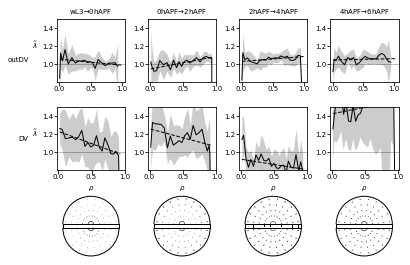

In [66]:
#rois = ['outDV', 'DV']
#devstages = ['upcrawling','whitePupa','2hAPF','4hAPF']


figsize = (15*cm_, 9*cm_)

nbcols = len(devstage_combinations)
nbrows = 3

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = figsize
                      )
main_ax = fig.add_subplot(111, frameon=False)

for j in range(nbcols):
    devstage_init = devstage_combinations.loc[j,'devstage_init']
    devstage_final = devstage_combinations.loc[j,'devstage_final']

    for i in range(2):
        roi = rois[i]

        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = devstage_init + r'$ \to $' + devstage_final
        if j == 0:
            ylabel = r'$\tilde{\lambda}$'
        if i == 1:#nbrows-1:
            xlabel = r'$\rho$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            yticks = [1.0, 1.2, 1.4]
            #xlim = (0,155)
            ylim = (0.8, 1.5) 
        else:
            xticks = [0, 0.5, 1]
            yticks = [1.0, 1.2, 1.4]
            #xlim = (0,780)
            ylim = (0.8, 1.5)
        
        ax = get_subplot(ax, df = None,#k_diff, 
                         stat_df=k_diff_w_aniso_stat, query_str = query_str, x_col = 'ref_pathlength_scaled_beta_mean', y_col = 'lambda_anisotropic', 
                         mean_linewidth=lw,
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim, 
                         mean_color="black", #color_dict[devstage_init],
                        )
        ax = get_subplot(ax, df = None, 
                         stat_df = k_diff_w_aniso_stat, query_str = query_str, 
                         x_col_mean='ref_pathlength_scaled_beta_mean', y_col_mean ='fit_lambda_anisotropic',
                         mean_linewidth=lw,
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         mean_linestyle='--',error_style = None, mean_label = 'fit', 
                         mean_color="black",#color_dict[devstage_init],
                        )
        #ax.legend()
        ax.grid(visible=False)
        ax.set_xlabel(xlabel, fontsize = Medium_font_size)
        ax.set_ylabel(ylabel, fontsize = Medium_font_size, rotation = 'horizontal', labelpad = Medium_font_size)
        ax.tick_params(axis='both', which='major', labelsize=Medium_font_size, pad = 0)
        ax.set_title(title, fontsize = Medium_font_size, pad = Small_font_size)
        ax.axhline(y = 1.0, linewidth = lw/2, color = "gray", zorder = 0)
        
    ax = axs[2,j]
    ax = get_nematic_subplot(ax, stage_init=devstage_init, stage_final=devstage_final, lambda_name = "lambda_anisotropic_coeffs", fit_lambdas_df=fit_lambdas_df,
                             quiver_scale=quiver_scale, quiver_width=quiver_width, DV_width = DV_width,
                            )
        
        
fig.tight_layout()

plt.xlabel('', fontsize = Medium_font_size, labelpad = 0)
plt.ylabel('', fontsize = Medium_font_size, labelpad = 0, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1, 2]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['', 'DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = Medium_font_size, 
                    pad = 4*Medium_font_size, # if two columns
                    #pad = 30, #if four columns
                    rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = Medium_font_size, x = 0)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)

fig.tight_layout(pad = 0.2)


os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/lambda_anisotropic_' + genotype + '.pdf', bbox_inches = 'tight')

### Height analysis

In [67]:
#There are four different files with the data

df_names = ["../data/height_volume/ecadGFPnbG4HeightVolumneTrunkated-acrossDV.pkl",
            "../data/height_volume/ecadGFPnbG4HeightVolumneTrunkated-alongDV.pkl",
            "../data/height_volume/ecadGFPnbG4myoVIHeightVolumneTrunkated-acrossDV.pkl",
            "../data/height_volume/ecadGFPnbG4myoVIHeightVolumneTrunkated-alongDV.pkl"
           ]
#combine all files into a single dataframe
df_Height = pd.DataFrame()
for df_name in df_names:
    df_Height = pd.concat([df_Height, pd.read_pickle(df_name)])

devstage_map = {
                "96hAEL":"96hAEL",
                "120hAEL":"120hAEL",
                "upcrawling":"wL3",
                "whitePupa":"0hAPF",
                "2hAPF":"2hAPF",
                "4hAPF":"4hAPF",
                "6hAPF":"6hAPF",
               }
df_Height["devstage"] = [devstage_map[x] for x in df_Height["devstage"].values]
df_Height = df_Height.rename(columns={"disc": "discName"})
df_Height = df_Height[df_Height['genotype'] == genotype]
df = df_Height
df.head()

,genotype,devstage,discName,region,k_dist,cell_id,k_dist_pathlength,area,linelength,height,volume,distanceFraction,k_fromDV,roi
0,ecadGFPnbG4,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8,outDV,13,10439,26.362206,2.606868,26.0,24.4,63.607569,0.820286,NaN,NaN
1,ecadGFPnbG4,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8,outDV,13,10439,26.362206,2.606868,26.0,24.5,63.868255,0.820286,NaN,NaN
2,ecadGFPnbG4,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8,outDV,13,10439,26.362206,2.606868,26.0,22.5,58.654520,0.820286,NaN,NaN
3,ecadGFPnbG4,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8,outDV,13,11563,26.416047,1.512509,26.0,24.4,36.905231,0.821961,NaN,NaN
4,ecadGFPnbG4,96hAEL,20220517_ecadGFPnbG4_96hAEL_disc8,outDV,13,11563,26.416047,1.512509,26.0,24.5,37.056482,0.821961,NaN,NaN


In [68]:
groupby_cols = ['devstage', 'region', 'discName', 'k_dist']
#here we pool cells within a ring and calculate the mean and std
df_pool_k = df.groupby(groupby_cols).agg('mean').reset_index() 
#we offset k_dist values if the rings do not start with k_dits = 0
k_dist_offset = df.groupby(['discName']).k_dist.agg('min')#.reset_index().set_index('discName') #some discs can have k starting from non-zero value, so we offset them by the starting k
#df_pool_k['k_dist'] = df_pool_k['k_dist'] - k_dist_offset[df_pool_k['discName'].values].values #offsetting k values


#scale pathlength
pathlength_max = df_pool_k.groupby(['discName']).k_dist_pathlength.agg('max')
df_pool_k['pathlength_scaled'] = df_pool_k['k_dist_pathlength']/pathlength_max[df_pool_k['discName'].values].values

In [69]:
groupby_cols = ['devstage', 'region', 'k_dist']
#here we pool discs within a devstage and calculate the mean and std
df_pool_devstage = df_pool_k.groupby(groupby_cols).agg(['mean', 'std']).reset_index()
colnames = [x[0]+'_'+x[1] if x[0] not in groupby_cols else x[0] for x in df_pool_devstage.columns]
df_pool_devstage.columns = colnames #removing multi-indexing

df_pool_devstage.head()

,devstage,region,k_dist,cell_id_mean,cell_id_std,k_dist_pathlength_mean,k_dist_pathlength_std,area_mean,area_std,linelength_mean,...,height_mean,height_std,volume_mean,volume_std,distanceFraction_mean,distanceFraction_std,k_fromDV_mean,k_fromDV_std,pathlength_scaled_mean,pathlength_scaled_std
0,0hAPF,DV,0,10575.842857,242.062470,0.000000,0.000000,6.138776,1.899830,0.000000,...,35.728751,3.450837,214.481586,52.654957,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0hAPF,DV,1,10613.352387,110.687154,2.740585,0.197002,7.049269,0.976519,2.771303,...,35.664722,3.429032,249.595224,27.747053,0.032621,0.001879,0.0,0.0,0.035095,0.001250
2,0hAPF,DV,2,10534.355983,141.625504,5.952463,0.394122,6.803410,0.972501,5.927690,...,35.571150,3.465918,239.662778,19.986769,0.070965,0.005600,0.0,0.0,0.076312,0.004181
3,0hAPF,DV,3,10515.141896,132.495449,9.463610,0.746017,6.795584,1.264079,9.442669,...,35.660233,3.568059,239.837254,31.293652,0.112913,0.011232,0.0,0.0,0.121321,0.008412
4,0hAPF,DV,4,10571.566821,150.008576,12.758039,1.085376,6.757545,1.057610,12.749598,...,35.542429,3.593406,238.444880,30.935569,0.152149,0.014992,0.0,0.0,0.163503,0.011652


[]

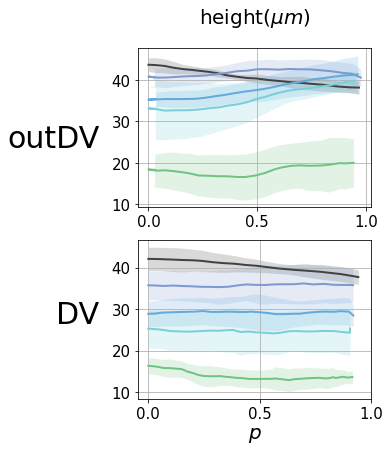

In [70]:
#rois = ['outDV', 'DV']
#devstages = ['upcrawling','whitePupa','2hAPF','4hAPF']
devstages = ["wL3","0hAPF","2hAPF","4hAPF","6hAPF",]

nbcols = 1
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = (4.5*nbcols, (10/3)*nbrows)
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(len(devstages)):
        
        devstage = devstages[j]
        query_str = '(devstage == "' + devstage + '") & (region == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = 'height' + r'$(\mu m)$' 
        if (j == 0) or (nbcols == 1):
            ylabel =''
        if (i == nbrows-1) or (nbrows == 1):
            xlabel = r'$p$'
        if roi == 'DV':
            xticks = [0, 0.5, 1]
            #yticks = [0, 10, 20]
            #xlim = (0,1)
            #ylim = (-2, 27)
        else:
            xticks = [0, 0.5, 1]
            #yticks = [0, 10, 20]
            #xlim = (0,1)
            #ylim = (-2, 27)
        
        ax = get_subplot(ax, df = None,  #df_pool_k, 
                         stat_df = df_pool_devstage, df_cases_col='discName',
                         query_str = query_str, x_col = 'distanceFraction', y_col = 'height', 
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         individual_color=color_dict[devstage],individual_linewidth =1.2, 
                         mean_color=color_dict[devstage],mean_linewidth =2,
                         mean_label=devstage, ylabelpad = 0,
                        )
        
    ax.grid(visible=True)
    #ax.legend(fontsize = 12)
    
fig.tight_layout()

plt.xlabel('', fontsize = 40, labelpad = 30)
plt.ylabel('', fontsize = 40, labelpad = 70, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = 15, pad = 15, rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = 30, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



#os.makedirs('plots/',exist_ok=True)
#plt.savefig('plots/k_vs_N.pdf', bbox_inches = 'tight')


In [71]:

prop = 'height'

[height_diff, height_diff_stat] = get_prop_diff_vs_dist(df_pool_k, prop = prop,operation = 'divide',
                                                   devstage_combinations=devstage_combinations, fit_deg=2
                                              )


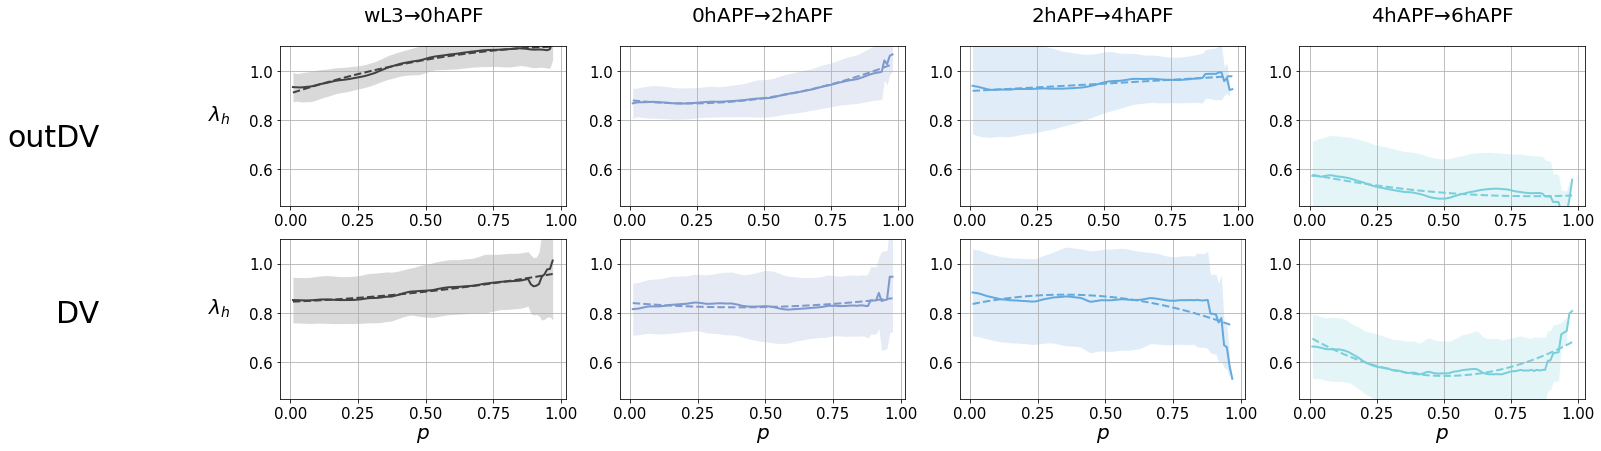

In [72]:
#rois = ['outDV', 'DV']
#devstages = ['upcrawling','whitePupa','2hAPF','4hAPF']


nbcols = len(devstage_combinations)
nbrows = len(rois)

fig,axs = plt.subplots(nbrows, nbcols,
                       figsize = (5*nbcols, (10/3)*nbrows)
                      )
main_ax = fig.add_subplot(111, frameon=False)


for i in range(nbrows):
    
    roi = rois[i]
    
    for j in range(nbcols):
        
        devstage_init = devstage_combinations.loc[j,'devstage_init']
        devstage_final = devstage_combinations.loc[j,'devstage_final']
        
        query_str = '(devstage_init == "' + devstage_init + '") & (devstage_final == "' + devstage_final + '") & (roi == "' + roi + '")'
        
        if nbcols == 1:
            ax = axs[i]
        elif nbrows == 1:
            ax = axs[j]
        else:
            ax = axs[i,j]
            
        title = ''
        ylabel = ''
        xlabel = ''
        xticks = None
        yticks = None
        xlim = None
        ylim = None
        if i == 0:
            title = devstage_init + r'$ \to $' + devstage_final
        if j == 0:
            ylabel = r'$\lambda_{h}$'
        if i == nbrows-1:
            xlabel = r'$p$'
        if roi == 'DV':
            xticks = [0, 0.25, 0.5, 0.75, 1]
            #yticks = [0.8,0.9,1,1.1, 1.2 ] 
            #xlim = (0,155)
            ylim = (0.45, 1.1) 
        else:
            xticks = [0, 0.25, 0.5, 0.75, 1]
            #yticks = [0.8, 0.9, 1, 1.1, 1.2]
            #xlim = (0,780)
            ylim = (0.45, 1.1)
        
        ax = get_subplot(ax, df = None, #el_diff, 
                         stat_df = height_diff_stat, query_str = query_str, x_col = 'dist_beta', y_col = prop+'_diff', 
                         mean_color = color_dict[devstage_init], mean_linewidth= 2, mean_alpha = 0.2, #properties of the mean line
                         xlabel = xlabel, ylabel = ylabel, title = title,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         error_style='fill_between'
                        )

        ax = get_subplot(ax, df = None, stat_df = height_diff_stat, query_str = query_str, 
                         x_col_mean='dist_beta', y_col_mean ='fit_'+prop+'_diff',
                         xlabel = xlabel, ylabel = ylabel, title = title, ylabelpad=30,
                         xticks = xticks, yticks = yticks, xlim = xlim, ylim = ylim,
                         mean_linewidth=2,mean_color = color_dict[devstage_init], mean_linestyle='--',
                         error_style = None, mean_label = 'fit'
                        )
        
        #ax.legend()
        ax.grid()
        
        
fig.tight_layout()

plt.xlabel('', fontsize = 40, labelpad = 30)
plt.ylabel('', fontsize = 40, labelpad = 70, rotation = 0)

plt.xlim(-0.5,nbcols -0.5)
plt.ylim(-0.5, nbrows -0.5)
        
#tick_intervals_x = col_vals
tick_intervals_y = [0, 1]

#tick_intervals_x_str = [str(round(x,2)) for x in tick_intervals_x]
tick_intervals_y_str = ['DV', 'outDV']

main_ax.tick_params(axis=u'both', which=u'both', length = 0, labelsize = 15, 
                    pad = 50, # if two columns
                    #pad = 30, #if four columns
                    rotation = 0)

#plt.xticks(range(len(col_vals)), tick_intervals_x_str, fontsize = 40)
main_ax.set_yticks(tick_intervals_y)
main_ax.set_yticklabels(tick_intervals_y_str, fontsize = 30, x = -0.1)

#main_ax.axvline(x = 0.42, color = 'blue', linewidth = 5)

main_ax.set_xticks([])
#plt.yticks([], [], fontsize = 40)



os.makedirs('plots/',exist_ok=True)
plt.savefig('plots/lambda_height_' + genotype + '.pdf', bbox_inches = 'tight')


In [73]:
prop = "height"
fit_lambdas_df = compile_fit_lambdas_for_sim(height_diff_stat, fit_lambdas_df = fit_lambdas_df, prop = prop, lambda_name = "lambda_height_coeffs")

In [74]:
#save the fit_lambdas_df
os.makedirs('fit_lambda_files/',exist_ok=True)
pickle.dump(fit_lambdas_df, open("fit_lambda_files/fit_lambdas_df_"+genotype+".pkl", 'wb'))
fit_lambdas_df.to_csv("fit_lambda_files/fit_lambdas_df_"+genotype+".csv", index=False)

In [75]:
fit_lambdas_df

,stage,stage_name,prop,value,stage_init,stage_final,roi
0,0,wL3 to 0hAPF,lambda_isotropic_coeffs,"[-0.1466314118835658, 1.2061157068172164]",wL3,0hAPF,outDV
1,1,0hAPF to 2hAPF,lambda_isotropic_coeffs,"[-0.15787417016378213, 1.1911198379881764]",0hAPF,2hAPF,outDV
2,2,2hAPF to 4hAPF,lambda_isotropic_coeffs,"[0.024352640924532057, 1.013409740373247]",2hAPF,4hAPF,outDV
3,3,4hAPF to 6hAPF,lambda_isotropic_coeffs,"[0.0062259322605448825, 1.319361586379148]",4hAPF,6hAPF,outDV
4,0,wL3 to 0hAPF,inDV_lambda_isotropic_coeffs,"[-0.13199526622899696, 1.1932208575078265]",wL3,0hAPF,DV
5,1,0hAPF to 2hAPF,inDV_lambda_isotropic_coeffs,"[0.009350122696798463, 0.9790886669606658]",0hAPF,2hAPF,DV
6,2,2hAPF to 4hAPF,inDV_lambda_isotropic_coeffs,"[0.06029699830255874, 1.1911338759978323]",2hAPF,4hAPF,DV
7,3,4hAPF to 6hAPF,inDV_lambda_isotropic_coeffs,"[-0.11605810466247961, 1.4660398553590621]",4hAPF,6hAPF,DV
8,0,wL3 to 0hAPF,lambda_Q_coeffs,"[-0.07368565578484423, 0.9991787571301044]",wL3,0hAPF,outDV
9,1,0hAPF to 2hAPF,lambda_Q_coeffs,"[0.03488257675627328, 0.9598279925897081]",0hAPF,2hAPF,outDV


# Extra plots

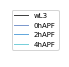

In [76]:
#custom legend
from matplotlib.lines import Line2D
"""custom_lines = [Line2D([0], [0], color="blue", lw=lw),
                Line2D([0], [0], color="gray", lw=lw),
                Line2D([0], [0], color="red", lw=lw)]"""
devstages = ["wL3", "0hAPF", "2hAPF", "4hAPF"]
custom_lines = [Line2D([0], [0], color = color_dict[devstage], lw = lw) for devstage in devstages]

figsize = (2.5*cm_, 2.5*cm_)
fig, ax = plt.subplots(figsize = figsize)
#lines = ax.plot(data)
ax.axis('off')
ax.legend(custom_lines, devstages, fontsize = Medium_font_size)
fig.savefig("plots/devstages_legend.pdf", bbox_inches = "tight")

In [77]:
fit_lambdas_df_wL3_to_4h = pd.read_pickle("fit_lambda_files/fit_lambdas_df_ecadGFPnbG4_only_4hAPF.pkl")

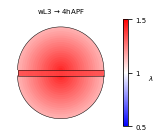

In [78]:
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_wL3_to_4h, DV_width = DV_width,
                           boundary_lw=lw/2, add_cbar = True, fontsize=Medium_font_size)
#ax = get_nematic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_wL3_to_4h, 
#                         lambda_name ="lambda_anisotropic_coeffs", DV_width = DV_width,
#                         quiver_scale=quiver_scale, quiver_width=quiver_width,
#                           boundary_lw=lw/2)
ax.set_title("wL3 " + r"$\to$" + " 4hAPF", fontsize = Medium_font_size)
plt.savefig("plots/WT_circ_plot_only_area.pdf", bbox_inches = "tight")

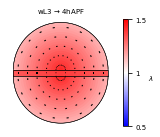

In [79]:
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_wL3_to_4h, DV_width = DV_width,
                           boundary_lw=lw/2, add_cbar=True, fontsize=Medium_font_size)
ax = get_nematic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_wL3_to_4h, 
                         lambda_name ="lambda_Q_coeffs", DV_width = DV_width,
                         quiver_scale=quiver_scale, quiver_width=quiver_width,
                           boundary_lw=lw/2)
ax.set_title("wL3 " + r"$\to$" + " 4hAPF", fontsize = Medium_font_size)
plt.savefig("plots/WT_circ_plot_area_elongation.pdf", bbox_inches = "tight")

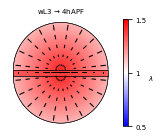

In [80]:
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_wL3_to_4h, DV_width = DV_width,
                           boundary_lw=lw/2, add_cbar=True, fontsize=Medium_font_size)
ax = get_nematic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_wL3_to_4h, 
                         lambda_name ="lambda_anisotropic_coeffs", DV_width = DV_width,
                         quiver_scale=quiver_scale, quiver_width=quiver_width,
                           boundary_lw=lw/2)
ax.set_title("wL3 " + r"$\to$" + " 4hAPF", fontsize = Medium_font_size)
plt.savefig("plots/WT_circ_plot_all.pdf", bbox_inches = "tight")

In [81]:
#Myosin plots
fit_lambdas_df_MyoVI = pd.read_pickle("fit_lambda_files/fit_lambdas_df_ecadGFPnbG4myoVI_only_4hAPF.pkl")

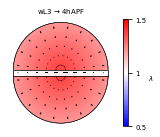

In [82]:
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_MyoVI, DV_width = DV_width,
                           boundary_lw=lw/2, add_cbar=True, fontsize=Medium_font_size)
ax = get_nematic_subplot(ax, stage_init="wL3", stage_final="4hAPF", fit_lambdas_df=fit_lambdas_df_MyoVI, 
                         lambda_name ="lambda_anisotropic_coeffs", DV_width = DV_width,
                         quiver_scale=quiver_scale, quiver_width=quiver_width,
                           boundary_lw=lw/2)
ax.set_title("wL3 " + r"$\to$" + " 4hAPF", fontsize = Medium_font_size)
plt.savefig("plots/MyoVI_circ_plot_all.pdf", bbox_inches = "tight")

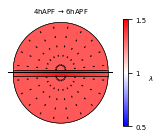

In [84]:
#6hAPF plot
fit_lambdas_df_w_6hAPF = pd.read_pickle("fit_lambda_files/fit_lambdas_df_ecadGFPnbG4_w_6hAPF.pkl")

figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_subplot(ax, stage_init="4hAPF", stage_final="6hAPF", fit_lambdas_df=fit_lambdas_df_w_6hAPF, DV_width = DV_width,
                           boundary_lw=lw/2, add_cbar=True, fontsize=Medium_font_size)
ax = get_nematic_subplot(ax, stage_init="4hAPF", stage_final="6hAPF", fit_lambdas_df=fit_lambdas_df_w_6hAPF, 
                         lambda_name ="lambda_anisotropic_coeffs", DV_width = DV_width,
                         quiver_scale=quiver_scale, quiver_width=quiver_width,
                           boundary_lw=lw/2)
ax.set_title("4hAPF " + r"$\to$" + " 6hAPF", fontsize = Medium_font_size)
plt.savefig("plots/4hAPF_to_6hAPF_circ_plot_all.pdf", bbox_inches = "tight")


## Rough

I am trying to plot circles 

## Sample plot for visualization

In [ ]:
import numpy as np
from matplotlib.patches import Circle, Wedge, Rectangle, Arc
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import matplotlib

def get_isotropic_subplot(ax, DV_width = 0.2, stage_init = "wL3", stage_final = "4hAPF", N = 20, zorder = 2, add_cbar = False, fit_lambdas_df = None, add_boundary = True):
    #source : https://matplotlib.org/stable/gallery/shapes_and_collections/patch_collection.html#sphx-glr-gallery-shapes-and-collections-patch-collection-py
    #source : https://matplotlib.org/stable/gallery/shapes_and_collections/artist_reference.html#sphx-glr-gallery-shapes-and-collections-artist-reference-py
    #to control z order 
    #https://matplotlib.org/stable/tutorials/colors/colors.html#sphx-glr-tutorials-colors-colors-py
    #add each patch separately to ax and mention its zorder

    patches = []

    R = 1
    w = R/N

    center_bottom = (0,-DV_width/2)
    center_top = (0,DV_width/2)

    lambda_name = "lambda_isotropic_coeffs"
    roi = "outDV"
    query_str = 'stage_init == "' + stage_init + '" and stage_final == "' + stage_final + '" and roi == "' + roi + '" and prop == "'+ lambda_name + '"'
    poly_obj = np.poly1d(fit_lambdas_df.query(query_str)["value"].iloc[0])
    radii = [(N-i)*w for i in range(N)]#[(i+1)*w for i in range(N)]
    patches = [Wedge((center_bottom), radius, 180, 360) for radius in radii] #add width = w in Wedge if you want an annulus
    colors = [poly_obj(radius) for radius in radii]

    patches += [Wedge((center_top), radius,0,180) for radius in radii]
    colors += [poly_obj(radius) for radius in radii]
    #zorders += [i for i in range(N)]

    #adding rectangles inisde DV boundary
    lambda_name = "inDV_" + lambda_name
    roi = "DV"
    query_str = '(stage_init == "' + stage_init + '") & (stage_final == "' + stage_final + '") & (roi == "' + roi + '")'
    poly_obj = np.poly1d(fit_lambdas_df.query(query_str)["value"].iloc[0])
    x_vals = [-(N-i)*w for i in range(N)]
    patches += [Rectangle((x_val,-DV_width/2), 2*np.abs(x_val), DV_width) for x_val in x_vals]
    colors += [poly_obj(np.abs(x_val)) for x_val in x_vals]

    ###########
    #colors = 100*np.random.random(len(patches))
    norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.5)
    p = PatchCollection(patches, cmap=matplotlib.cm.bwr, norm = norm, alpha=1, edgecolor = None, zorder = zorder)
    p.set_array(colors)
    ax.add_collection(p)
    ax.set_xlim((-1.1*(R+DV_width), 1.1*(R+DV_width)))
    ax.set_ylim((-1.1*(R+DV_width), 1.1*(R+DV_width)))
    ax.set_aspect("equal")
    ax.axis('off')
    if add_cbar: fig.colorbar(p, ax = ax)
    ###########
    
    if add_boundary:
        p = Arc(center_bottom, 2,2, theta1=180, theta2=360, linewidth=1, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        p = Arc(center_top, 2,2, theta1=0, theta2=180, linewidth=1, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        p = Rectangle((-1,center_bottom[1]), 2, DV_width, linewidth=1, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        
    return(ax)


In [ ]:
fig, ax = plt.subplots()
ax = get_isotropic_subplot(ax, fit_lambdas_df=fit_lambdas_df)

## Plotting nematics

In [ ]:

def get_quiver_specs(R = 1, theta = 0, roi = "outDV", center = (0,0), stage_init ="wL3", stage_final = "4hAPF", lambda_name ="lambda_isotropic_coeffs", fit_lambdas_df = None):
    
    #from roi, get the location
    if roi == "outDV":
        x,y = R*np.cos(theta)+center[0], R*np.sin(theta)+center[1]
    if roi == "DV":
        x,y = R,theta
    
    #from roi get the correct lambda fit poynomial
    query_str = 'stage_init == "' + stage_init + '" and stage_final == "' + stage_final + '" and roi == "' + roi + '" and prop == "'+lambda_name+'"'
    poly_obj = np.poly1d(fit_lambdas_df.query(query_str)["value"].iloc[0])
    #from the polynomial get the value
    lambda_val = poly_obj(np.abs(R))
    #from the value get the direction
    if roi == "outDV" and lambda_val < 1 :
        u = -np.abs(1 - lambda_val)*np.sin(theta)
        v = np.abs(1 - lambda_val)*np.cos(theta)
    if roi == "outDV" and lambda_val >= 1 :
        u = np.abs(1 - lambda_val)*np.cos(theta)
        v = np.abs(1 - lambda_val)*np.sin(theta)
    if roi == "DV" and lambda_val < 1 :
        u = 0
        v = np.abs(1 - lambda_val)
    if roi == "DV" and lambda_val >= 1 :
        u = np.abs(1 - lambda_val)
        v = 0
    
    return(x,y,u,v)


In [ ]:

def get_nematic_subplot(ax, stage_init="wL3", stage_final = "4hAPF", lambda_name ="lambda_anisotropic_coeffs", DV_width = 0.2, zorder = 10, fit_lambdas_df = None, add_boundary = True,
                        quiver_scale = 5, quiver_width = 0.005, 
                       ):
    #https://stackoverflow.com/questions/34375345/how-does-pythons-matplotlib-pyplot-quiver-exactly-work
    dtheta = 0.1
    Rs= np.linspace(0.1,0.9, 5)#1
    center_bottom = (0,-DV_width/2)
    center_top = (0,DV_width/2)

    x = []
    y = []
    u = []
    v = []
    
    roi = "outDV"
    #bottom
    thetas = np.linspace(np.pi+dtheta, 2*np.pi-dtheta,10)
    for R in Rs:
        for theta in thetas:
            x_,y_,u_,v_ = get_quiver_specs(R=R, theta=theta, roi=roi, center=center_bottom, stage_init=stage_init, stage_final=stage_final, lambda_name=lambda_name, fit_lambdas_df = fit_lambdas_df)
            x += [x_]
            y += [y_]
            u += [u_]
            v += [v_]

    #top
    thetas = np.linspace(0+dtheta, np.pi-dtheta, 10)
    for R in Rs:
        for theta in thetas:
            x_,y_,u_,v_ = get_quiver_specs(R=R, theta=theta, roi=roi, center=center_top, stage_init=stage_init, stage_final=stage_final, lambda_name=lambda_name, fit_lambdas_df = fit_lambdas_df)
            x += [x_]
            y += [y_]
            u += [u_]
            v += [v_]

    #DV
    roi = "DV"
    lambda_name ="inDV_"+lambda_name
    x_DVs = np.linspace(-0.9, 0.9,10) #np.concatenate([Rs,-Rs])
    for y_DV in [0]: 
        for x_DV in x_DVs: 
            #pass x and y values as R and theta
            x_,y_,u_,v_ = get_quiver_specs(R=x_DV, theta=y_DV, roi=roi, center=(0,0), stage_init=stage_init, stage_final=stage_final, lambda_name=lambda_name, fit_lambdas_df = fit_lambdas_df)
            x += [x_]
            y += [y_]
            u += [u_]
            v += [v_]

    #add quivers
    ax.quiver(x,y,u,v, scale = quiver_scale, headwidth = 0, headlength = 0, headaxislength = 0, width = quiver_width, pivot = "mid", zorder = zorder) #increase scale value to decrease length of lines

    if add_boundary:
        p = Arc(center_bottom, 2,2, theta1=180, theta2=360, linewidth=1, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        p = Arc(center_top, 2,2, theta1=0, theta2=180, linewidth=1, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        p = Rectangle((-1,center_bottom[1]), 2, DV_width, linewidth=1, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)

    ax.set_aspect("equal")
    ax.set_xlim((-1.1*(R+DV_width), 1.1*(R+DV_width)))
    ax.set_ylim((-1.1*(R+DV_width), 1.1*(R+DV_width)))
    ax.axis('off')

    return(ax)


In [ ]:
fig,ax = plt.subplots()
ax = get_nematic_subplot(ax, fit_lambdas_df=fit_lambdas_df, add_boundary = True, lambda_name = "lambda_rearrangement_coeffs", quiver_scale = 10, quiver_width=0.005)
#ax = get_isotropic_subplot(ax, fit_lambdas_df=fit_lambdas_df, add_boundary = False, lambda_name = "lambda_Q_coeffs")